# Rydberg Hamiltonian Tutorial 

This notebook walks through the construction of Rydberg Hamiltonian by hand and verifies that the `qcom.hamiltonians` builder reproduces the same matrix.

## Contents
- [1. Introduction](#1-introduction)
- [2. Setup](#2-setup)
- [3. Simple Two-Site LatticeRegister](#3-simple-two-site-latticeregister)
    - [Plotting A Register](#plot-the-register)
    - [Parameter Choices](#parameter-choices)
    - [Drive Term $\Omega$](#drive-term-omega)
    - [Detuning Term $\Delta$](#detuning-term-delta)
    - [Interaction Term $V_{ij}$](#interaction-term-vij)
    - [The Full Hamiltonian](#the-full-hamiltonian)
- [4. Compare Simple Hamiltonian With QCOM](#4-compare-simple-hamiltonian-with-qcom)
    - [Drive Term With Phase](#drive-term-with-phase)
    - [Exponential Form](#exponential-form)
- [5. Compare Complex Hamiltonian With QCOM](#5-compare-complex-hamiltonian-with-qcom)
- [6. Sparse Vs. Dense Matrices](#6-sparse-vs-dense-matrices)



## 1. Introduction

The Rydberg Hamiltonian for a set of two-level systems can be written as

$$
H = H_{\text{drive}} + H_{\text{detuning}} + H_{\text{interaction}}\,,
$$

with

$$
H_{\mathrm{drive}} =\frac{1}{2}\sum_i \Omega_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) \qquad
H_{\text{detuning}} = - \sum_i \Delta_i n_i,\qquad
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j,
$$

where $n_i = (I - \sigma^z_i)/2$ projects onto the Rydberg state.

In this tutorial we show several explicit calculations for small system rydberg hamiltonians. We then compare with what we would get from the QCOM package

## 2. Setup

We import NumPy along with the `qcom` utilities that assemble the Rydberg Hamiltonian.

In [1]:
import numpy as np
import qcom as qc
import matplotlib.pyplot as plt

## 3. Simple Two-Site LatticeRegister

We place two sites along the $x$-axis separated by $1\,\mu\text{m}$.

We will only consider a 2 site system for now as it makes the explicit computation of the hamiltonian (4 x 4) much easier.

In [2]:
# 1) Use meters for microns
reg = qc.LatticeRegister([
    (0.0,    0.0, 0.0),
    (1e-6,   0.0, 0.0),   # 1 µm in meters
])

#### Plot The Register

In the case of the Rydberg hamiltonian it is appropriate to refer to each site as an atom. By plotting the register you can see which index corresponds to which atom.

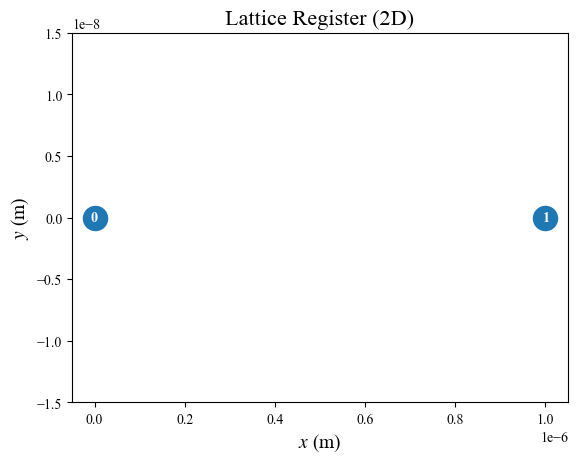

In [3]:
ax = reg.plot(show_index=True, s=300)
plt.show()

## Parameter choices

We will first choose site-independent parameters to show how the Hamiltonian is calculated. This simplifies the general Hamiltonian down to

$$
H_{\mathrm{drive}} =\frac{\Omega}{2}\sum_i \big(\cos(\phi)\sigma_i^x + \sin(\phi)\sigma_i^y\big), \qquad
H_{\text{detuning}} = - \Delta \sum_i  n_i, \qquad
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j.
$$

Since the values of $\Omega$ and $\Delta$ are the same for every site, the expressions become simpler.

Convention: In this tutorial we use angular frequency units. That is, $\Omega$ and $\Delta$ should be given in rad/s, and $C_6$ in rad·s⁻¹·m⁶. To convert from Hz to rad/s, multiply by $2\pi$.

For simplicity, let us pick:
	•	$\Omega = 1 ,\text{rad/s}$
	•	$\Delta = 1 ,\text{rad/s}$
	•	$\phi = 0$

⸻

The interaction coefficient $V_{ij}$ is defined as

$$
V_{ij} = \frac{C_6}{r_{ij}^6},
$$

where $C_6$ is element-dependent.

For rubidium, a typical value is

$$
C_6 \approx 5.42\times 10^6 , \text{MHz},\mu\text{m}^6.
$$

Converted to the units expected by the builder:

\begin{aligned}
C_6 &=
2\pi \times 5.42\times 10^6 \,\text{Hz}\,\mu\text{m}^6 \\
&= 2\pi \times 5.42\times 10^6 \times 10^{6} \,\text{Hz}\,\mu\text{m}^6 \\
&= 2\pi \times 5.42\times 10^{12} \,\text{Hz}\,\mu\text{m}^6 \\
&\to \; 2\pi \times 5.42\times 10^{12} \times 10^{-36}\,\text{rad/s}\,m^6 \\
&\approx 3.41\times 10^{-23} \,\text{rad/s}\,m^6.
\end{aligned}

However, to keep the algebra clean, we will simply take

$$
C_6 = 1.
$$

⸻

The simplified Hamiltonian is then

$$
H_{\mathrm{drive}} = \tfrac{1}{2}\sum_i \sigma_i^x
= \tfrac{1}{2}\sum_i \big( \ket{g_i}\bra{r_i} + \ket{r_i}\bra{g_i} \big), \qquad
H_{\text{detuning}} = -\sum_i  n_i, \qquad
H_{\text{interaction}} = \sum_{i<j} \frac{n_i n_j}{r_{ij}^6}.
$$

⸻

Side Note

The two ways of writing the drive term are equivalent because

$$
\ket{g}  =
\begin{bmatrix}
1 \\ 0
\end{bmatrix},
\qquad
\ket{r} =
\begin{bmatrix}
0 \\ 1
\end{bmatrix}.
$$

Thus

$$
\ket{g_i}\bra{r_i} + \ket{r_i}\bra{g_i} =
\begin{bmatrix}
0 & 1 \\ 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\ 1 & 0
\end{bmatrix}

\begin{bmatrix}
0 & 1 \\ 1 & 0
\end{bmatrix}
= \sigma^x.
$$

⸻


### Drive Term ($\Omega$) <a id='drive-term-omega'></a>

For $\phi$=0, the drive reduces to
$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}\sum_{i=0}^1 \sigma_i^x
=\frac{\Omega}{2}\bigl(\sigma_1^x+\sigma_2^x\bigr).
$$

Using the computational basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$ with
$$
\sigma^x=\begin{bmatrix}0&1\\[2pt]1&0\end{bmatrix},\quad
I=\begin{bmatrix}1&0\\[2pt]0&1\end{bmatrix},
$$
the single-site operators on two sites are
$$
\sigma_1^x=\sigma^x\otimes I
=\begin{bmatrix}
0&0&1&0\\
0&0&0&1\\
1&0&0&0\\
0&1&0&0
\end{bmatrix},
\qquad
\sigma_2^x=I\otimes\sigma^x
=\begin{bmatrix}
0&1&0&0\\
1&0&0&0\\
0&0&0&1\\
0&0&1&0
\end{bmatrix}
$$

Where $\otimes$ is the tensor product of two matrices.  

Therefore,  
$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}\bigl(\sigma_1^x+\sigma_2^x\bigr)
=\frac{\Omega}{2}
\begin{bmatrix}
0&1&1&0\\
1&0&0&1\\
1&0&0&1\\
0&1&1&0
\end{bmatrix}
$$

For the tutorial’s choice $\Omega=1$,
$$
H_{\mathrm{drive}}
=\frac{1}{2}
\begin{bmatrix}
0&1&1&0\\
1&0&0&1\\
1&0&0&1\\
0&1&1&0
\end{bmatrix}
$$

---
#### Side Note

The drive matrix (without the factor $\Omega/2$ and with $\phi=0$) can be written with row/column labels:

\[
\begin{array}{c|cccc}
    & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 1 & 1 & 0 \\
|01\rangle & 1 & 0 & 0 & 1 \\
|10\rangle & 1 & 0 & 0 & 1 \\
|11\rangle & 0 & 1 & 1 & 0 \\
\end{array}
\]

It is clear that nonzero entries occur only when the row and column bitstrings differ at exactly one site.

We can formalize this with a "flip table" $\mathrm{flip}\in\{0,1\}^{2^N\times 2^N}$:
$$
\mathrm{flip}[m,n] =
\begin{cases}
1, & \text{if } \mathrm{HammingDistance}(m,n)=1,\\[2pt]
0, & \text{otherwise.}
\end{cases}
$$
Equivalently, there exists a site $k\in\{0,\dots,N-1\}$ such that
$$
n = m \oplus 2^{k},
$$
where $\oplus$ is bitwise XOR and $1\ll k$ flips bit $k$.

This is exactly how `rydberg.py` computes this matrix.

---

### Detuning term ($\Delta$) <a id = 'detuning-term-delta'></a>

The detuning contribution is
$$
H_{\text{detuning}} \;=\; - \sum_{i=0}^{N-1} \Delta_i\, n_i,
\qquad
n_i \;=\; \frac{I-\sigma_i^z}{2},
$$
so it is **diagonal in the computational basis**.   
For a basis state $|b_{N-1}\dots b_1 b_0\rangle$ with $b_i\in\{0,1\}$ indicating ground/rydberg occupancy at site $i$,
$$
\langle b|\,H_{\text{detuning}}\,|b\rangle \;=\; - \sum_{i=0}^{N-1} \Delta_i\, b_i,
$$
and all off-diagonal elements vanish.

- **Uniform detuning** $\Delta_i=\Delta$: the diagonal entry is $-\Delta\, w(b)$, where $w(b)=\sum_i b_i$ is the Hamming weight (number of Rydberg excitations).
- **Site-dependent detuning**: the diagonal entry is a weighted sum $-\sum_i \Delta_i b_i$.

#### Two-site example ($N=2$, basis $\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$)

Uniform $\Delta$:
$$
H_{\text{detuning}} \;=\;
\begin{array}{c|cccc}
 & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & -\Delta & 0 & 0 \\
|10\rangle & 0 & 0 & -\Delta & 0 \\
|11\rangle & 0 & 0 & 0 & -(2\Delta)
\end{array}
$$

With site-dependent $(\Delta_0,\Delta_1)$:
$$
H_{\text{detuning}} \;=\;
\begin{array}{c|cccc}
 & |00\rangle & |01\rangle & |10\rangle & |11\rangle \\ \hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & -\Delta_1 & 0 & 0 \\
|10\rangle & 0 & 0 & -\Delta_0 & 0 \\
|11\rangle & 0 & 0 & 0 & -(\Delta_0+\Delta_1)
\end{array}
$$
All off-diagonal entries are zero because $n_i$ is diagonal in this basis.

Finally, since we set $\Delta$ = 1 for both sites in our example we have:

$$
H_{\text{detuning}} = 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -2 \\
\end{bmatrix}
$$
---

## Interaction Term ($V_{ij}$) 

The interaction contribution is

$$
H_{\text{interaction}} = \sum_{i<j} V_{ij} n_i n_j
\qquad
V_{ij} = \frac{C_6}{r_{ij}^6}
$$

where $n_i = (I-\sigma^z_i)/2$ projects onto Rydberg occupation at site $i$.
Because $n_i$ is diagonal in the computational basis, this entire term is diagonal as well: it only contributes when two sites are simultaneously excited.

For a basis state $\lvert b_{N-1}\dots b_1 b_0\rangle$ with $b_i\in{0,1}$ indicating excitation at site $i$, the diagonal entry is

$$
\langle b \lvert H_{\text{interaction}} \rvert b \rangle
= \sum_{i<j} V_{ij} b_i b_j.
$$

That is, every excited pair $(i,j)$ contributes an energy shift $V_{ij}$.

⸻

Two-site example ($N=2$, basis ${|00\rangle, |01\rangle, |10\rangle, |11\rangle}$)

There is only one pair $(0,1)$ with interaction $V_{01}$.
The interaction Hamiltonian is

$$
H_{\text{interaction}} =
\begin{array}{c|cccc}
& |00\rangle & |01\rangle & |10\rangle & |11\rangle \\
\hline
|00\rangle & 0 & 0 & 0 & 0 \\
|01\rangle & 0 & 0 & 0 & 0 \\
|10\rangle & 0 & 0 & 0 & 0 \\
|11\rangle & 0 & 0 & 0 & V_{01}
\end{array}
$$

Only the doubly excited state $\lvert 11\rangle$ feels the interaction, and it picks up an energy $V_{01}$.

⸻

Specializing to our parameters

For our chosen register with two sites separated by $r_{01}$,

$$
V_{01} = \frac{C_6}{r_{01}^6}.
$$

We set $C_6=1$ earlier for algebraic simplicity (though in reality $C_6$ has units of rad·s⁻¹·m⁶).
Thus

$$
V_{01} = \frac{1}{r_{01}^6}.
$$

For $r_{01} = 1,\mu\text{m} = 10^{-6},\text{m}$,

$$
V_{01} = \frac{1}{(10^{-6})^6} = 10^{36}.
$$

So the interaction Hamiltonian matrix is

$$
H_{\text{interaction}} =
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 10^{36}
\end{bmatrix}.
$$

⸻

Side note

The huge value at $1,\mu\text{m}$ separation is a consequence of choosing $C_6=1$.
For rubidium, realistic values are on the order of $10^9$–$10^{10}$ Hz·μm$^6$, which still produce very strong interactions at micron separations.

This is why atoms closer than $\sim 4,\mu\text{m}$ enter the strong blockade regime, where double excitations are effectively suppressed — the essence of the Rydberg blockade effect.
Experimentally, the drive ($\Omega$) and detuning ($\Delta$) must be made large to partially compete with this interaction scale.

⸻

### The full Hamiltonian

Now that we have computed all the separate terms, we can add them up to get the full Hamiltonian for this simple system. 

$$
H = H_{\text{drive}} + H_{\text{detuning}} + H_{\text{interaction}}
$$

$$
H = \frac{1}{2} \begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0
\end{bmatrix} 
+ 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -2 \\
\end{bmatrix} 
+
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 10^{36}
\end{bmatrix}
=
\begin{bmatrix}
0 & \frac{1}{2} & \frac{1}{2} & 0 \\
\frac{1}{2} & -1 & 0 & \frac{1}{2} \\
\frac{1}{2} & 0 & -1 & \frac{1}{2} \\
0 & \frac{1}{2} & \frac{1}{2} & 10^{36} - 2
\end{bmatrix}
$$

### General Site Independent (2x2 no phase) Hamiltonian

We can now generalize this hamiltonian using the analysis we've already done. Plugging this in we have:

$$
H 
=
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & -\Delta & 0 & \frac{\Omega}{2} \\
\frac{\Omega}{2} & 0 & -\Delta & \frac{\Omega}{2} \\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & \frac{C_6}{(r_{01})^6} - 2\Delta
\end{bmatrix}
$$

### General Site Dependent (2x2 no phase) Hamiltonian

In order to add site dependence we just add subscripts to $\Omega$ and $\Delta$. Note at this point it's important to note our convention of Most Significant Bit (MSB) = 0. This means the leftmost bit in the bitstring starts at 0 and we go from there. Starting with the left most bit and considering the flips you get the resulting matrix.

$$
H =
\begin{bmatrix}
0 & \frac{\Omega_1}{2} & \frac{\Omega_0}{2} & 0 \\
\frac{\Omega_1}{2} & -\Delta_1 & 0 & \frac{\Omega_0}{2} \\
\frac{\Omega_0}{2} & 0 & -\Delta_0 & \frac{\Omega_1}{2} \\
0 & \frac{\Omega_0}{2} & \frac{\Omega_1}{2} & \frac{C_6}{(r_{01})^6} - \Delta_0 - \Delta_1
\end{bmatrix}
$$


## 4. Compare Simple Hamiltonian With QCOM

Let's plug in our simple parameters into QCOM's RydbergHamiltonian builder to see if we get the same values we calculated directly above.

In [4]:
c6_simple = 1 # in rad·s⁻¹·m⁶
omega_simple = 1 # in rad·s⁻¹
delta_simple = 1 # in rad·s⁻¹
phase_simple = 0 # in radians

H_qcom = qc.build_rydberg(
    reg,
    Omega=omega_simple,
    Delta=delta_simple,
    C6=c6_simple,
    Phi=phase_simple)

H_dense = H_qcom.to_dense()
print("QCOM Hamiltonian:\n", H_dense)

print(H_dense[3,3])
print(H_dense[3,3] - (10**(36)))  # Will show significant numerical error

QCOM Hamiltonian:
 [[ 0.e+00  5.e-01  5.e-01  0.e+00]
 [ 5.e-01 -1.e+00  0.e+00  5.e-01]
 [ 5.e-01  0.e+00 -1.e+00  5.e-01]
 [ 0.e+00  5.e-01  5.e-01  1.e+36]]
1.0000000000000002e+36
1.4757395258967641e+20


**Great!**   
We get exact agreement with our manually calculated Hamiltonian. I printed H[3,3] explicitly to address a point of confusion. You might think this result does not agree with our calculation — after all, the value should be slightly less than $10^{36}$, right?

The reality is that for such large numbers, Python can only represent values approximately. The trailing “2” at the end is not us adding 2 to the number; it is an artifact of numerical rounding error. Even if we subtract $10^{36}$, the result is still enormous. This is because the spacing between representable floating-point numbers at $10^{36}$ is about
$10^{36} \times 2^{-52} \approx 10^{20}$,
which is exactly what we observe.

To avoid these numerical issues, one should choose units and parameters carefully so values remain within a manageable range. Larger floating-point formats (e.g. long double, arbitrary precision) can help a bit, but only up to a point.

---


#### More Realistic Example

So far, we have used simplified parameters (e.g. $\Omega=\Delta=C_6=1$).  
While pedagogically useful, this choice leads to unphysical scales — for instance, an astronomically large interaction at $ 1 \mu m$.  

To illustrate a more **physically meaningful regime**, let’s instead choose representative values closer to those used in rubidium Rydberg experiments:

- **Interaction coefficient**:  
  $$
  C_6 \;\approx\; 5.42\times 10^6 \,\text{MHz}\,\mu\text{m}^6
  \;\;\approx\;\; 5.42\times 10^{-24}\,\text{Hz}\cdot \text{m}^6
  $$
  (converted into SI units).
- **Rabi frequency**:  
  $$
  \Omega \;=\; 4\pi \,\text{MHz} \;\;\approx\;\; 1.26\times 10^{7}\,\text{Hz}.
  $$
- **Detuning**:  
  $$
  \Delta \;=\; 8\pi \,\text{MHz} \;\;\approx\;\; 2.51\times 10^{7}\,\text{Hz}.
  $$
- **Lattice spacing**:  
  $$
  a \;=\; 5\,\mu\text{m} \;=\; 5\times 10^{-6}\,\text{m}.
  $$

These values yield interaction energies on the order of tens of MHz for micron separations — large enough to induce blockade effects, but not the artificial $10^{36}$ scale we encountered with the toy model.  

---

**Conversion Note:**  
The QCOM Hamiltonian builder expects angular frequencies (rad/s).  
To convert from ordinary frequency in Hz, multiply by $2\pi$:  
$$
f \;\; [\text{Hz}] \quad \longrightarrow \quad \omega = 2\pi f \;\; [\text{rad/s}].
$$

In [5]:
reg = qc.LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic_hz = 5.42 * (10**-24) # Hz m^6
C6_realistic = C6_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹·m⁶
Omega_realistic_hz = 1.26 * (10**7) # Hz
Omega_realistic = Omega_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Delta_realistic_hz = 2.51 * (10**7)  # Hz
Delta_realistic = Delta_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Phi_realistic = 0.0 # still zero for now
H_realistic = qc.build_rydberg(
    reg,
    Omega=Omega_realistic,
    Delta=Delta_realistic,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
print("Realistic Hamiltonian:\n", H_dense_realistic)

Realistic Hamiltonian:
 [[ 0.00000000e+00  3.95840674e+07  3.95840674e+07  0.00000000e+00]
 [ 3.95840674e+07 -1.57707951e+08  0.00000000e+00  3.95840674e+07]
 [ 3.95840674e+07  0.00000000e+00 -1.57707951e+08  3.95840674e+07]
 [ 0.00000000e+00  3.95840674e+07  3.95840674e+07  1.86409542e+09]]


### Site-Dependent Hamiltonian

So far, we have assumed **site-independent parameters** where all atoms share the same $\Omega$ and $\Delta$.  
To introduce **site dependence**, we allow $\Omega$ and $\Delta$ to vary across lattice sites by passing them as arrays instead of scalars.

As an example, consider a two-site register with:

- Drive amplitudes:
  $$
  \Omega_0 = 1.26\times 10^{7}, \qquad \Omega_1 = 2\,\Omega_0
  $$
  (values given here in Hz, **before conversion** to rad/s).

- Detunings:
  $$
  \Delta_0 = 2.51\times 10^{7}, \qquad \Delta_1 = 2\,\Delta_0
  $$
  (again specified in Hz, before conversion).

---

**Implementation Note:**  
The Hamiltonian builder requires **angular frequencies** (rad/s).  
Thus, in practice you should convert each entry of $\Omega$ and $\Delta$ as:
$$
\omega_i = 2\pi \, f_i,
$$
before passing them to the builder.  
This way, the site-dependent structure is preserved while ensuring physical units are correct.

In [6]:
reg = qc.LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

# C6 coefficient
C6_realistic_hz = 5.42 * (10**-24) # Hz m^6
C6_realistic = C6_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹·m⁶

# Omega
Omega_realistic_hz = 1.26 * (10**7) # Hz
Omega_realistic = Omega_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Omega_values = [Omega_realistic, 2*Omega_realistic]

# Delta
Delta_realistic_hz = 2.51 * (10**7)  # Hz
Delta_realistic = Delta_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Delta_values = [Delta_realistic, 2*Delta_realistic]

# Phi (phase)
Phi_realistic = 0.0 # still zero for now

# Build the hamiltonian
H_realistic = qc.build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
print("Realistic Hamiltonian:\n", H_dense_realistic)

Realistic Hamiltonian:
 [[ 0.00000000e+00  7.91681349e+07  3.95840674e+07  0.00000000e+00]
 [ 7.91681349e+07 -3.15415902e+08  0.00000000e+00  3.95840674e+07]
 [ 3.95840674e+07  0.00000000e+00 -1.57707951e+08  7.91681349e+07]
 [ 0.00000000e+00  3.95840674e+07  7.91681349e+07  1.70638747e+09]]


### Drive Term with Phase

Earlier we set $\phi = 0$, but what if $\phi$ is not necessarily 0?  
The only term that is affected is the Drive Term. Recall that the general drive term is:

$$
H_{\mathrm{drive}} =\frac{1}{2}\sum_i \Omega_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) \qquad
$$

Where
$$
\sigma^x = 
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\qquad \&
\qquad
\sigma^y
=
\begin{bmatrix}
0 & -i \\
i & 0 
\end{bmatrix}
$$

Previously we showed that

$$
\sigma^x \otimes I + I \otimes \sigma^x =
\begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0 
\end{bmatrix}
$$
 
Doing the same operation with $\sigma^y$ we find:

$$
\sigma^y \otimes I + I \otimes \sigma^y =
\begin{bmatrix}
0 & -i & -i & 0 \\
i & 0 & 0 & -i \\
i & 0 & 0 & -i \\
0 & i & i & 0 
\end{bmatrix}
$$

Now including $\phi$ we have:

$$
\sum_i \big(\cos(\phi)\sigma_i^x + \sin(\phi) \sigma_i^y\big) 
= 
\begin{bmatrix}
0 & \cos(\phi) -i\sin(\phi) & \cos(\phi) - i\sin(\phi) & 0 \\
\cos(\phi) + i\sin(\phi) & 0 & 0 & \cos(\phi) -i\sin(\phi) \\
\cos(\phi) +i\sin(\phi) & 0 & 0 & \cos(\phi) - i\sin(\phi) \\
0 & \cos(\phi) +i\sin(\phi) & \cos(\phi) +i\sin(\phi) & 0 
\end{bmatrix}
$$

### Site independent drive term

The site independent drive term is then

$$
H_{drive} = 
\frac{\Omega}{2}
\begin{bmatrix}
0 & \cos(\phi) -i\sin(\phi) & \cos(\phi) - i\sin(\phi) & 0 \\
\cos(\phi) + i\sin(\phi) & 0 & 0 & \cos(\phi) -i\sin(\phi) \\
\cos(\phi) +i\sin(\phi) & 0 & 0 & \cos(\phi) - i\sin(\phi) \\
0 & \cos(\phi) +i\sin(\phi) & \cos(\phi) +i\sin(\phi) & 0 
\end{bmatrix}
$$

### Site dependent drive term

Once again to get the site dependent we bring Omega within the sum and give it a subscript. The result is:


$$
H_{drive} = 
\begin{bmatrix}
0 & \frac{\Omega_1}{2}(\cos(\phi) -i\sin(\phi)) & \frac{\Omega_0}{2}(\cos(\phi) - i\sin(\phi)) & 0 \\
\frac{\Omega_1}{2}(\cos(\phi) + i\sin(\phi)) & 0 & 0 & \frac{\Omega_0}{2}(\cos(\phi) -i\sin(\phi)) \\
\frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & 0 & 0 & \frac{\Omega_1}{2}(\cos(\phi) - i\sin(\phi)) \\
0 & \frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & \frac{\Omega_1}{2}(\cos(\phi) +i\sin(\phi)) & 0 
\end{bmatrix}
$$

### Fully General 2 x 2 Rydberg Hamiltonian

Thus we are finally able to get the fully general 2 x 2 Rybderg Hamiltonian. 

$$
H = 
\begin{bmatrix}
0 & \frac{\Omega_1}{2}(\cos(\phi) -i\sin(\phi)) & \frac{\Omega_0}{2}(\cos(\phi) - i\sin(\phi)) & 0 \\
\frac{\Omega_1}{2}(\cos(\phi) + i\sin(\phi)) & -\Delta_1 & 0 & \frac{\Omega_0}{2}(\cos(\phi) -i\sin(\phi)) \\
\frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & 0 & -\Delta_0 & \frac{\Omega_1}{2}(\cos(\phi) - i\sin(\phi)) \\
0 & \frac{\Omega_0}{2}(\cos(\phi) +i\sin(\phi)) & \frac{\Omega_1}{2}(\cos(\phi) +i\sin(\phi)) & \frac{C_6}{r_{01}^6}-\Delta_1 - \Delta_0
\end{bmatrix}
$$

### Exponential form $e^{\pm i\phi}$ <a id = 'exponential-form'></a>

Using Euler’s identity $\cos\phi \mp i\sin\phi = e^{\mp i\phi}$, the drive matrices above can be rewritten compactly.

Site-independent phase

$$
H_{\mathrm{drive}}
=\frac{\Omega}{2}
\begin{bmatrix}
0 & e^{-i\phi} & e^{-i\phi} & 0 \\
e^{+i\phi} & 0 & 0 & e^{-i\phi} \\
e^{+i\phi} & 0 & 0 & e^{-i\phi} \\
0 & e^{+i\phi} & e^{+i\phi} & 0
\end{bmatrix}.
$$

Site-dependent amplitudes and a single global phase

If only $\Omega$ varies by site (indices follow the MSB=0 convention: site 0 is the left bit, site 1 is the right bit), then

$$
H_{\mathrm{drive}}
=
\begin{bmatrix}
0 & \tfrac{\Omega_1}{2}e^{-i\phi} & \tfrac{\Omega_0}{2}e^{-i\phi} & 0 \\
\tfrac{\Omega_1}{2}e^{+i\phi} & 0 & 0 & \tfrac{\Omega_0}{2}e^{-i\phi} \\
\tfrac{\Omega_0}{2}e^{+i\phi} & 0 & 0 & \tfrac{\Omega_1}{2}e^{-i\phi} \\
0 & \tfrac{\Omega_0}{2}e^{+i\phi} & \tfrac{\Omega_1}{2}e^{+i\phi} & 0
\end{bmatrix}.
$$

Fully site-dependent phases $\phi_i$

More generally, a flip on site i carries its own phase $e^{\pm i\phi_i}$. With MSB=0 (left bit = site 0, right bit = site 1):

$$
H_{\mathrm{drive}}
=
\begin{bmatrix}
0 & \tfrac{\Omega_1}{2}e^{-i\phi_1} & \tfrac{\Omega_0}{2}e^{-i\phi_0} & 0 \\
\tfrac{\Omega_1}{2}e^{+i\phi_1} & 0 & 0 & \tfrac{\Omega_0}{2}e^{-i\phi_0} \\
\tfrac{\Omega_0}{2}e^{+i\phi_0} & 0 & 0 & \tfrac{\Omega_1}{2}e^{-i\phi_1} \\
0 & \tfrac{\Omega_0}{2}e^{+i\phi_0} & \tfrac{\Omega_1}{2}e^{+i\phi_1} & 0
\end{bmatrix}.
$$

Reading rule: entries that connect two basis states differing by a flip on site i get a factor $\tfrac{\Omega_i}{2}e^{\pm i\phi_i}$; the sign in the exponent is chosen so that Hermiticity holds (upper-triangle entries use $e^{-i\phi_i}$, lower-triangle use $e^{+i\phi_i})$.

## 5. Compare Complex Hamiltonian with QCOM

So far, we have worked with $\phi = 0$, which kept the Hamiltonian real.  
Introducing a **non-zero phase** makes the drive term complex, since it combines both $\sigma^x$ and $\sigma^y$ contributions with relative weights $\cos\phi$ and $\sin\phi$.

Let us take the same setup as before, but now include a finite phase:

- Interaction strength:
  $$
  C_6 = 5.42\times 10^{-24}\ \text{Hz}\cdot m^6
  $$
  (converted from $5420441.1326\ \text{MHz}\,\mu m^6$).

- Drive amplitudes:
  $$
  \Omega_0 = 1.26\times 10^{7}, \qquad \Omega_1 = 2\,\Omega_0
  $$

- Detunings:
  $$
  \Delta_0 = 2.51\times 10^{7}, \qquad \Delta_1 = 2\,\Delta_0
  $$

- Phase:
  $$
  \phi = \tfrac{\pi}{4}
  $$

- Atom spacing:
  $$
  a = 5\,\mu m = 5\times 10^{-6}\, m
  $$

---

**Remark:**  
With $\phi \neq 0$, the off-diagonal matrix entries in the drive term pick up complex phases of the form $e^{\pm i\phi}$.  
The QCOM Hamiltonian builder automatically handles this, allowing us to directly verify the complex-valued structure of $H$.

In [7]:
reg = qc.LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic_hz = 5.42 * (10**-24) # Hz m^6
C6_realistic = C6_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹·m⁶


Omega_realistic_hz = 1.26 * (10**7) # Hz
Omega_realistic = Omega_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹

Omega_values = [Omega_realistic, 2*Omega_realistic]
Delta_realistic_hz = 2.51 * (10**7)  # Hz
Delta_realistic = Delta_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Delta_values = [Delta_realistic, 2*Delta_realistic]
Phi_realistic = np.pi/4  # example non-zero phase. Already in radians
H_realistic = qc.build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_dense_realistic = H_realistic.to_dense()
for row in H_dense_realistic:
    print(["{0:.4e}".format(x) for x in row])

['0.0000e+00+0.0000e+00j', '5.5980e+07-5.5980e+07j', '2.7990e+07-2.7990e+07j', '0.0000e+00+0.0000e+00j']
['5.5980e+07+5.5980e+07j', '-3.1542e+08+0.0000e+00j', '0.0000e+00+0.0000e+00j', '2.7990e+07-2.7990e+07j']
['2.7990e+07+2.7990e+07j', '0.0000e+00+0.0000e+00j', '-1.5771e+08+0.0000e+00j', '5.5980e+07-5.5980e+07j']
['0.0000e+00+0.0000e+00j', '2.7990e+07+2.7990e+07j', '5.5980e+07+5.5980e+07j', '1.7064e+09+0.0000e+00j']


## 6. Sparse Vs. Dense Matrices

As the dimension of the Hilbert space grows, Rydberg Hamiltonians become extremely sparse: most of the matrix entries are zero.

Why is this the case?
- The Hilbert space dimension for N atoms is $2^N$.
- Each drive operator ($\sigma^x$ or $\sigma^y$) only flips one qubit at a time, meaning each computational basis state connects to at most N others.
- Similarly, the detuning and interaction terms are diagonal, so they only contribute $2^N$ nonzero entries (one per basis state).

This means the total number of nonzero entries in H scales like
$$
\text{nnz}(H) \approx N \cdot 2^N \quad (\text{off-diagonal from drives}) \;+\; 2^N \quad (\text{diagonal terms}),
$$

while the full dense matrix has

$$
(2^N)^2 = 4^N \quad \text{entries in total}.
$$

So the fraction of nonzeros is approximately

$$
\frac{\text{nnz}(H)}{4^N} \;\approx\; \frac{N+1}{2^N},
$$

which decays exponentially with N.
For example:
	•	N=10: fraction $\approx \frac{11}{1024} \sim 1\%$.
	•	N=20: fraction $\approx \frac{21}{1,048,576} \sim 2 \times 10^{-5}$.

This exponential sparsity is why sparse representations are not just helpful, but essential for realistic system sizes.

---

### Practical usage

In this package, you can build either dense or sparse Hamiltonians. Dense matrices are useful for small toy examples and debugging, but for anything beyond a few atoms, you should always use the sparse implementation.

The only change is to call ```.to_sparse()``` instead of ```.to_dense()```.
The result is a ```scipy.sparse.csr_matrix```, which stores only the nonzero entries.

Example:

In [8]:
reg = qc.LatticeRegister([
    (0.0,    0.0, 0.0),
    (5e-6,   0.0, 0.0),   # 5 µm in meters
])

C6_realistic_hz = 5.42 * (10**-24) # Hz m^6
C6_realistic = C6_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹·m⁶

Omega_realistic_hz = 1.26 * (10**7) # Hz
Omega_realistic = Omega_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Omega_values = [Omega_realistic, 2*Omega_realistic]
Delta_realistic_hz = 2.51 * (10**7)  # Hz
Delta_realistic = Delta_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Delta_values = [Delta_realistic, 2*Delta_realistic]
Phi_realistic = np.pi/4  # example non-zero phase
H_realistic = qc.build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)
H_sparse_realistic = H_realistic.to_sparse()
print(H_sparse_realistic)  



<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 12 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	0j
  (0, 1)	(55980325.02079542-55980325.02079541j)
  (0, 2)	(27990162.51039771-27990162.510397706j)
  (1, 0)	(55980325.02079542+55980325.02079541j)
  (1, 1)	(-315415902.42041516+0j)
  (1, 3)	(27990162.51039771-27990162.510397706j)
  (2, 0)	(27990162.51039771+27990162.510397706j)
  (2, 2)	(-157707951.21020758+0j)
  (2, 3)	(55980325.02079542-55980325.02079541j)
  (3, 1)	(27990162.51039771+27990162.510397706j)
  (3, 2)	(55980325.02079542+55980325.02079541j)
  (3, 3)	(1706387465.7238307+0j)


### Building A Large System With Sparse

Sparse Hamiltonian took 0.008646965026855469 seconds to generate
Dense Hamiltonian took 1.6558399200439453 seconds to generate
Finding ground state took 0.09622502326965332 seconds for sparse Hamiltonian
Ground state energy: -3419338789.4835496
Finding ground state took 0.05094408988952637 seconds for dense Hamiltonian
Ground state energy: -3419338789.4835434
Percent difference between sparse and dense ground state energies: 1.812889402976329e-13%


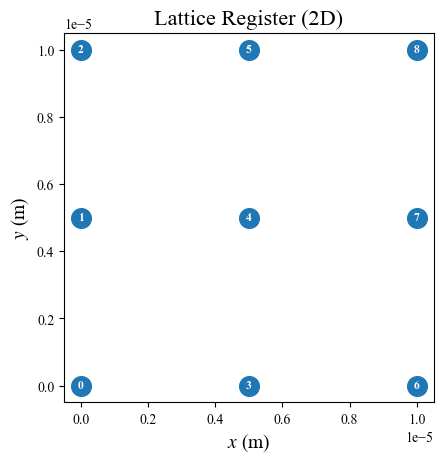

In [9]:
reg = qc.LatticeRegister()
# build 3 rows of 3 atoms
for i in range(3):
    for j in range(3):
        reg.add((i*5e-6, j*5e-6, 0.0))  # 5 µm spacing
ax = reg.plot()

C6_realistic_hz = 5.42 * (10**-24) # Hz m^6
C6_realistic = C6_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹·m⁶

Omega_realistic_hz = 1.26 * (10**7) # Hz
Omega_realistic = Omega_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Omega_values = [i * Omega_realistic for i in range(1,10)]
Delta_realistic_hz = 2.51 * (10**7)  # Hz
Delta_realistic = Delta_realistic_hz * (2 * np.pi)  # convert to rad·s⁻¹
Delta_values = [i * Delta_realistic for i in range(1,10)]
Phi_realistic = [i * (np.pi/4) for i in range(1,10)]  # example non-zero phase
H_realistic = qc.build_rydberg(
    reg,
    Omega=Omega_values,
    Delta=Delta_values,
    C6=C6_realistic,
    Phi=Phi_realistic)

# import time and measure how long it takes to generate sparse and dense
import time 
time_before_sparse = time.time()
H_sparse_realistic = H_realistic.to_sparse()
time_after_sparse = time.time()
print(f"Sparse Hamiltonian took {time_after_sparse - time_before_sparse} seconds to generate")
time_before_dense = time.time()
H_dense_realistic = H_realistic.to_dense()
time_after_dense = time.time()
print(f"Dense Hamiltonian took {time_after_dense - time_before_dense} seconds to generate")

# now import the solver and see how long it takes to find the ground state

from qcom.solvers.static import ground_state
time_before_gs = time.time()
E0, psi0 = ground_state(H_sparse_realistic)
time_after_gs = time.time()
print(f"Finding ground state took {time_after_gs - time_before_gs} seconds for sparse Hamiltonian")
print(f"Ground state energy: {E0}")
time_before_gs_dense = time.time()
E0_dense, psi0_dense = ground_state(H_dense_realistic)
time_after_gs_dense = time.time()
print(f"Finding ground state took {time_after_gs_dense - time_before_gs_dense} seconds for dense Hamiltonian")
print(f"Ground state energy: {E0_dense}")

# show the accuracy of the sparse vs the dense
percent_diff = abs((E0 - E0_dense) / E0_dense) * 100
print(f"Percent difference between sparse and dense ground state energies: {percent_diff}%")
